# Generating Models to Data

Author:  Dominic Doud and Natasha Batalha  (NASA Ames Research Center)

You should have already installed PICASO (which can be found [here](https://natashabatalha.github.io/picaso/installation.html)) and run the previous notebook [AnalyzeExoplanet_picaso_setup.ipynb](https://colab.research.google.com/drive/1zPjFDy8HTy4nwsFbAbq73UJMZkTMZGCT?usp=sharing) to download the Wasp 39b data. The setup notebook needs to be run only **once**. 

**NOTE: This tutorial is aimed at both beginner and advanced levels.**

<div class="alert alert-block alert-info">

#### Rewa & Natasha's notes for improving this notebook

In an ideal world, in this notebook you would be directed to download data needed specifically for this tutorial (e.g., ZENODO WASP-39 b data). I've already done that, and it is stored in ./expolanet_modeling_tutorial/

Ideally in the previous notebook, you would have downloaded data needed for PICASO in general (opacities, grp, virga, sonora ck). For me, this is all** stored in ./picaso_data/

**Actually for notebook 2 to run, it appears grp needs to be one directory above the git-tracked picaso directory. So I had to remove grp from the ./picaso_data sub-directory, and instead it put it in the main working directory (i.e. in PICASO).

</div>

# Check PICASO Imports

Here are the two main PICASO functions you will be exploring:

`justdoit` contains all the spectroscopic modeling functionality you will need in these exercises.

`justplotit` contains all the of the plotting functionality you will need in these exercises.

Tips if you are not familiar with Python or `jupyter notebooks`:

- Run a cell by clicking shift-enter. You can always go back and edit cells. But, make sure to rerun them if you edit it. You can check the order in which you have run your cells by looking at the bracket numbers (e.g. [1]) next to each cell.

- In any cell you can write `help(INSERT_FUNCTION)` and it will give you documentation on the input/output

- If you type `jdi.` followed by "tab" a box will pop up with all the available functions in `jdi`. This applies to any python function (e.g. `numpy`, `pandas`)
  
- If you type class.function?, for example `jdi.mean_regrid`, it will describe the function and its parameters/returns. This also applies to any class with a function.

## Define the directory

We have created a special condensed version of all the PICASO and VIRGA reference data, that includes everything you need to complete this exercise. **All you need to do is define your path picaso_tutorial_dir for Python, the same as the setup notebook.**

In [1]:
import os
# Check you have picaso
from picaso import justdoit as jdi
from picaso import justplotit as jpi
import picaso.opacity_factory as op
import numpy as np

jpi.output_notebook()
# define the same directory you did in the setup, where you have extracted the example data files
# picaso_tutorial_dir = '/Users/nbatalh1/Documents/data/planets/WASP-39b/'

/Applications/anaconda3/envs/picaso312/lib/python3.12/site-packages/picaso-3.3-py3.12.egg/picaso/justdoit.py:55: UserWarning: Your code version is 3.3 but your reference data version is 3.2. For some functionality you may experience Keyword errors. Please download the newest ref version or update your code: https://github.com/natashabatalha/picaso/tree/master/reference
  warnings.warn(f"Your code version is {__version__} but your reference data version is {ref_v}. For some functionality you may experience Keyword errors. Please download the newest ref version or update your code: https://github.com/natashabatalha/picaso/tree/master/reference")


Loading BokehJS ...

In [2]:
##### REWA #####

# Define the working directory (where you should have put the downloaded grp files)
working_dir = os.getcwd()

# Define the directory where you put the downloaded general PICASO data files
picaso_data_dir = '/Users/rewabush/Desktop/Rewa/NASA/PICASO/picaso_data'

# Define the directory where you put the downloaded WASP-39 b data files
w39_data_dir = '/Users/rewabush/Desktop/Rewa/NASA/PICASO/exoplanet_modeling_tutorial'

In [3]:
##### REWA #####

# Define path to your zenodo files
zenodo_dir = os.path.join(w39_data_dir, 'ZENODO')
print(zenodo_dir)

# Define path to your virga files
mieff_dir = os.path.join(picaso_data_dir, 'virga')
print(mieff_dir)

# Define path to your sonora correlated k files
ck_dir = os.path.join(picaso_data_dir, 'correlated_k_tables')
print(ck_dir)

# Define path to your stellar grp files
grp_dir = os.path.join(working_dir, 'grp')
print(grp_dir)

/Users/rewabush/Desktop/Rewa/NASA/PICASO/exoplanet_modeling_tutorial/ZENODO
/Users/rewabush/Desktop/Rewa/NASA/PICASO/picaso_data/virga
/Users/rewabush/Desktop/Rewa/NASA/PICASO/picaso_data/correlated_k_tables
/Users/rewabush/Desktop/Rewa/NASA/PICASO/grp


In [4]:
# Double check that your reference file path has been set
import os
refdata = os.getenv("picaso_refdata")
print(refdata)
# If you are having trouble setting this, you can do it right here in the command line
#os.environ["picaso_refdata"]= add your path here AND COPY AND PASTE ABOVE
# IT WILL NEED TO GO ABOVE YOUR PICASO IMPORT

/Users/rewabush/Desktop/Rewa/NASA/PICASO/picaso/reference


# Observed Spectrum

Before we start modeling a planet to match WASP-39 b, let's get hold of WASP-39 b's actual observed spectrum in data format, so we can plot it next to our modeled ones. If you did [part 1 of this tutorial](https://github.com/Kappibw/JWST/blob/main/2_retrieving_jwst_spectra.ipynb), you already downloaded the data prepared by the scientists who wrote [the CO2 discovery paper](https://arxiv.org/pdf/2208.11692.pdf).

If you haven't done part 1, you can download the data from [here](https://zenodo.org/record/6959427#.Yx936-zMJqv). Download the .zip, and then look for `ZENODO/TRANSMISSION_SPECTRA_DATA/EUREKA_REDUCTION.txt`.
**This file was downloaded as part of the Setup notebook.**

Or you can take your own reduced data.

In [5]:
#eureka_reduction_path = picaso_tutorial_dir+'/ZENODO/TRANSMISSION_SPECTRA_DATA/EUREKA_REDUCTION.txt'

In [6]:
##### REWA #####
eureka_reduction_path = zenodo_dir+'/TRANSMISSION_SPECTRA_DATA/EUREKA_REDUCTION.txt'

In [7]:
# Import ascii
from astropy.io import ascii

# Confirm can read the file
observed_data = ascii.read(eureka_reduction_path)

In [8]:
observed_data.colnames

['wavelength',
 'bin_width',
 'tr_depth',
 'tr_depth_errneg',
 'tr_depth_errpos',
 'ecl_depth',
 'ecl_depth_errneg',
 'ecl_depth_errpos']

Let's plot the observed data and see what we are working with!

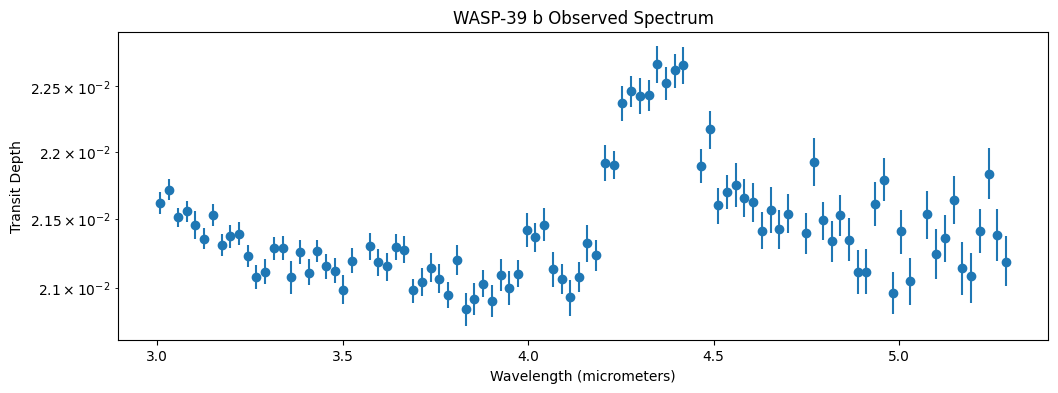

In [9]:
plt=jpi.plt
plt.figure(figsize=(12,4))
plt.errorbar(observed_data['wavelength'], observed_data['tr_depth'],
             [observed_data['tr_depth_errneg'], observed_data['tr_depth_errpos']],fmt='o')
plt.title('WASP-39 b Observed Spectrum')
plt.yscale('log')
plt.ylabel('Transit Depth')
plt.xlabel('Wavelength (micrometers)')
plt.show()

# Spectra Ingredients

Now what? Let's slowly build up a model that can match this data. What do we need?

## PICASO Basics


### List of what you will need before getting started

1. Planet properties

- planet radius
- planet mass
- planet's equilibrium temperature

2. Stellar properties

- stellar log gravity
- stellar effective temperature
- stellar metallicity

3. Opacities (how do molecules and atoms absorb light under different pressure/temperature conditions)



# Basic Inputs

## Cross Section Connection

All rapid radiative transfer codes rely on a database of pre-computed cross sections. Cross sections are computed by using line lists in combination with critical molecular pressure broadening parameters. Both can either be derived from theoretical first principles (e.g., [UCL ExoMol's line lists](https://www.exomol.com/)), measured in a lab, and/or some combination thereof (e.g., [HITRAN/HITEMP line lists](https://hitran.org/)).

When cross sections are initially computed, a resolution ($\lambda/\Delta \lambda$) is assumed. Cross sections are computed on a line-by-line nature and therefore usually computed for R~1e6. For JWST we are often interested in large bands (e.g. 1-14 $\mu$m). Therefore we need creative ways to speed up these runs. You will usually find one of two methods: correlated-k tables and resampled cross sections. [Garland et al. 2019](https://arxiv.org/pdf/1903.03997.pdf) is a good resource on the differences between these two.

For this demonstration we will use the resampled cross section method. **The major thing to note about using resampled cross sections** is that you have to compute your model at ~100x higher resolution than your data, but then must bin it down to a comparable resolution as your data so you can compare them. You will note that the opacity file you downloaded is resampled at R=10,000. Therefore you will note that **in this tutorial we will always bin the model down to R=100** before comparing with the data.

**The overall idea is that we are just simply intializing PICASO to operate, create a "connection" to the models/spectral tools, in that wavelength (in microns) with the respective opacity range.**

<div class="alert alert-block alert-info">
^Can this be clarified?
</div>

In [10]:
opa = jdi.opannection(wave_range=[2.7,6])

## Set Basic Planet and Stellar Inputs

Second step is to define the basic planet parameters. Depending on the kind of model you want to compute (transmission vs. emission vs. reflected light), there are different requirements for the minimum set of information you need to include.

For WASP-39 b, since we have planet mass, radius, and all the necessary stellar specifications, we will be thorough in our inputs and include all parameters.

We can create an object called w39 that represents the planet WASP-39 b. We then assign values to that object. We already know the temperature, radius, metallicity, and surface gravity of the host star, so we can assign those values to the parent star under w39.star. We also know the mass and radius of the planet, so we can assign those values to the planet under w39.gravity (named thus because mass and radius will be used to compute the planet's surface gravity). As we move through the tutorial and make climate models etc., we will be doing these calculations on the object w39.

In [11]:
# Create that object or "case"
w39 = jdi.inputs()

# Describe the star 
w39.star(opa, temp=5400 , database='phoenix',
         metal=0.01, logg=4.45, radius=0.9, radius_unit=jdi.u.R_sun )

# Describe the planet
w39.gravity(mass=0.28, mass_unit=jdi.u.M_jup,
             radius=1.27, radius_unit=jdi.u.R_jup)


In [12]:
# To get information about a function, you can use '?'
w39.star?

Signature:
w39.star(
    opannection,
    temp=None,
    metal=None,
    logg=None,
    radius=None,
    radius_unit=None,
    semi_major=None,
    semi_major_unit=None,
    database='ck04models',
    filename=None,
    w_unit=None,
    f_unit=None,
)
Docstring:
Get the stellar spectrum using pysynphot and interpolate onto a much finer grid than the 
planet grid. 

Parameters
----------
opannection : class picaso.RetrieveOpacities
    This is the opacity class and it's needed to get the correct wave info and raman scattering cross sections
temp : float 
    (Optional) Teff of the stellar model if using the stellar database feature. 
    Not needed for filename option. 
metal : float 
    (Optional) Metallicity of the stellar model if using the stellar database feature. 
    Not needed for filename option. 
logg : float 
    (Optional) Logg cgs of the stellar model if using the stellar database feature. 
    Not needed for filename option. 
radius : float 
    (Optional) Radius of the s

## Set Climate and Chemistry

We now need to think about how we can model the climate and chemistry of this system. For the sake of this tutorial we will start really simple, then move forward to something more complex.

**For climate**, we will explore these levels in this tutorial

1. Isothermal (now)
2. Radiative-convective (next section)

**For chemistry**, we will explore these levels in this tutorial

1. Chemical Equilibrium


### Pressure
If we imagine our "nlevels" as equally spaced altitude bands on the planet, then we will assign pressures to decrease logarithmically as altitude increases.

Gas is compressible and tends to behave in that way in planetary atmospheres (including on Earth).

In [13]:
nlevels = 50
# Logspace goes from base^(start) to base^(end)
# so here we are going from 10^-6 to 10^2, which is
# 1 microbar to 100 bars of pressure.
# This is an arbitrarily chosen range, but this is the most common.
pressure = np.logspace(-6,2,nlevels)

In [14]:
##### REWA #####

print(pressure)

[1.00000000e-06 1.45634848e-06 2.12095089e-06 3.08884360e-06
 4.49843267e-06 6.55128557e-06 9.54095476e-06 1.38949549e-05
 2.02358965e-05 2.94705170e-05 4.29193426e-05 6.25055193e-05
 9.10298178e-05 1.32571137e-04 1.93069773e-04 2.81176870e-04
 4.09491506e-04 5.96362332e-04 8.68511374e-04 1.26485522e-03
 1.84206997e-03 2.68269580e-03 3.90693994e-03 5.68986603e-03
 8.28642773e-03 1.20679264e-02 1.75751062e-02 2.55954792e-02
 3.72759372e-02 5.42867544e-02 7.90604321e-02 1.15139540e-01
 1.67683294e-01 2.44205309e-01 3.55648031e-01 5.17947468e-01
 7.54312006e-01 1.09854114e+00 1.59985872e+00 2.32995181e+00
 3.39322177e+00 4.94171336e+00 7.19685673e+00 1.04811313e+01
 1.52641797e+01 2.22299648e+01 3.23745754e+01 4.71486636e+01
 6.86648845e+01 1.00000000e+02]


### Isothermal Temperature

Next we need to decide how the temperature of the atmosphere varies with pressure. On Earth, temperature generally drops as you travel further from the Earth's surface, i.e. higher in altitude and lower in pressure. But that is not always the case. For simplicity, we'll start by assuming the temperature of WASP-39 b's atmosphere is constant with pressure, which is called "isothermal." As our models get more sophisticated, we'll be able to refer back to this simple case.

In [15]:
# We can see from exo.MAST that the equilibrium temp
# of WASP 39 b is 1120 kelvin, so let's use a scale
# of temperatures based on that.
equilibrium_temperature = 1120.55
isothermal_temperature = np.zeros(nlevels) + equilibrium_temperature

In [16]:
##### REWA #####

print(isothermal_temperature)

[1120.55 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55
 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55
 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55
 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55
 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55 1120.55
 1120.55 1120.55 1120.55 1120.55 1120.55]


#### Setting the Atmosphere in PICASO

So far we have described the parent star and the planet. Now let's define the planet's atmosphere. Note, this is a common workflow, where you start by creating an object (w39) and then slowly add parameters (information) as you go.

In [17]:
w39.atmosphere(df = jdi.pd.DataFrame({
                'pressure':pressure,
                'temperature':isothermal_temperature}))

### Chemistry 

Now we need to add the chemistry! PICASO has a prebuilt chemistry table that was computed by Channon Visscher. You can use it by adding it to your input case. Two more chemistry parameters are now going to be introduced:

1. M/H: Atmospheric metallicity
2. C/O ratio: Elemental carbon to oxygen ratio


#### Metallicity

<img src="https://stellarplanetorg.files.wordpress.com/2020/04/wakeforddalba2020_rs_mass_metallicity_v1.jpg?w=736" width="800">

Looking at a mass-metallicity plot (compiled in [Wakeford & Dalba 2020](https://ui.adsabs.harvard.edu/abs/2020RSPTA.37800054W/abstract)) might offer a good starting point to decide what the M/H of your planet might be. Here we can see WASP-39 b HST observations led to the inference of ~100xM/H. One tactic might be to start from that estimate. Another might be to use the Solar System extrapolated value (gray dashed line) as a first pass. Let's start with the latter as a first guess.

In [18]:
log_mh = 1.0 # log relative to solar
# so a value of 1 here represents 10^1 = 10x solar

#### C/O Ratio

The elemental ratio of carbon to oxygen controls the dominant carbon-bearing species. For instance, take a look at Figure 1 from the paper [C/O RATIO AS A DIMENSION FOR CHARACTERIZING EXOPLANETARY ATMOSPHERES](https://iopscience.iop.org/article/10.1088/0004-637X/758/1/36/pdf).

At low C/O, we see CO$_2$ and CO as the dominant form of carbon, and at high C/O we see CH$_4$ and CO as the dominant form of carbon.

C/O is given in PICASO in units relative to solar C/O, which is worth noting because you're not giving it the actual ratio of carbon to oxygen, but rather the ratio relative to the Solar C/O. Solar C/O is ~0.5 ([Asplund et al. 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...653A.141A/abstract)), and let's set our value to be the same as Solar (i.e. 1 relative to Solar).

In [19]:
c_o = 1 # relative to solar

Now we can ask PICASO to make us a mixture of molecules consistent with the relative M/H metallicity and relative C/O ratio we set up, and we can take a look at what it creates. We can look at the "atmosphere profile" which shows us the abundances of various molecules at different levels of our atmosphere (levels being places where temperature and pressure differ in the manner we defined above). 

This can help us find out which molecules we should really focus on during our analysis, and others that may be harder or redundant to look for based off of our C/O ratio and metallicity.

In [20]:
w39.chemeq_visscher(c_o, log_mh)

Running this function sets a dataframe in your inputs dictionary, which you can access now with `w39.inputs['atmosphere']['profile']`. You can see that PICASO has given us loads of different molecules to work with, but many have miniscule abundances (note some e-38 values in there).

In [21]:
w39.inputs['atmosphere']['profile'].head()

,pressure,temperature,e-,H2,H,H+,H-,H2-,H2+,H3+,...,Cs,CO2,HCN,C2H2,C2H4,C2H6,SiO,MgH,OCS,graphite
0,0.000001,1120.55,9.490315e-10,0.829371,0.000037,4.505256e-38,1.537986e-18,8.816532e-28,4.505256e-38,4.505256e-38,...,1.249933e-10,0.000018,4.153731e-14,9.628886e-23,3.709806e-27,1.310189e-33,7.121062e-08,1.997696e-16,4.806553e-08,4.500000e-38
1,0.000001,1120.55,7.790618e-10,0.829372,0.000031,4.505298e-38,1.523700e-18,1.054149e-27,4.505298e-38,4.505298e-38,...,1.189188e-10,0.000018,6.050700e-14,2.043128e-22,1.146517e-26,5.897597e-33,4.889768e-08,1.655482e-16,5.090137e-08,4.500000e-38
2,0.000002,1120.55,6.395334e-10,0.829374,0.000025,4.505340e-38,1.509547e-18,1.260395e-27,4.505340e-38,4.505340e-38,...,1.131394e-10,0.000018,8.813998e-14,4.335259e-22,3.543317e-26,2.654705e-32,3.357622e-08,1.371890e-16,5.390453e-08,4.500000e-38
3,0.000003,1120.55,5.249653e-10,0.829375,0.000021,4.505378e-38,1.495432e-18,1.506887e-27,4.505378e-38,4.505378e-38,...,1.076439e-10,0.000018,1.283903e-13,9.198541e-22,1.095008e-25,1.194894e-31,2.305577e-08,1.136884e-16,5.695836e-08,4.500000e-38
4,0.000004,1120.55,4.306428e-10,0.829377,0.000017,4.505378e-38,1.480360e-18,1.800108e-27,4.505378e-38,4.505378e-38,...,1.024490e-10,0.000018,1.869807e-13,1.950916e-21,3.381929e-25,5.374143e-31,1.583354e-08,9.421812e-17,5.863542e-08,4.500000e-38


### Reference Pressure

Lastly, we need to decide on a "reference pressure." If our planet was terrestrial, this would be the pressure at the surface, and therefore also the pressure corresponding to the radius of the planet. For gas giants like WASP-39 b, this is a bit more complicated -- there is no "surface," so we need to pick a pressure that corresponds to our planet's "radius" or surface, so that PICASO can calculate gravity as a function of altitude from that level.

We are selecting a pressure that we are essentially calling the bottom.

As we've discussed, a planet's radius changes depending on the wavelength at which you observe it -- it's that change that we are measuring with our spectra. But when we input the planet radius above, we picked a single number -- 1.27 `r_jup`. That number is an average calculated over a band of wavelengths. And so when we pick a reference pressure, we estimate roughly what level of the planet's atmosphere that averaged radius corresponds to (where, from the high pressure deep inside, to the low pressure at the exterior, does the chosen radius fall?).

PICASO suggests a reference pressure of 10 bar for gas giants, so we will start with that:

In [22]:
w39.approx(p_reference=10)

### Want to check your inputs so far?

If you want you can consult `w39.inputs` to check or reset inputs. Let's see how our WASP-39 b object is holding up!

In [23]:
w39.inputs.keys()

dict_keys(['version', 'calculation', 'phase', 'planet', 'climate', 'star', 'atmosphere', 'clouds', 'approx', 'disco', 'opacities', 'test_mode', 'output_dir'])

An atmosphere profile table shows the elemental abundances at each pressure level in our model atmosphere.

In [24]:
w39.inputs['atmosphere']['profile'].head()

,pressure,temperature,e-,H2,H,H+,H-,H2-,H2+,H3+,...,Cs,CO2,HCN,C2H2,C2H4,C2H6,SiO,MgH,OCS,graphite
0,0.000001,1120.55,9.490315e-10,0.829371,0.000037,4.505256e-38,1.537986e-18,8.816532e-28,4.505256e-38,4.505256e-38,...,1.249933e-10,0.000018,4.153731e-14,9.628886e-23,3.709806e-27,1.310189e-33,7.121062e-08,1.997696e-16,4.806553e-08,4.500000e-38
1,0.000001,1120.55,7.790618e-10,0.829372,0.000031,4.505298e-38,1.523700e-18,1.054149e-27,4.505298e-38,4.505298e-38,...,1.189188e-10,0.000018,6.050700e-14,2.043128e-22,1.146517e-26,5.897597e-33,4.889768e-08,1.655482e-16,5.090137e-08,4.500000e-38
2,0.000002,1120.55,6.395334e-10,0.829374,0.000025,4.505340e-38,1.509547e-18,1.260395e-27,4.505340e-38,4.505340e-38,...,1.131394e-10,0.000018,8.813998e-14,4.335259e-22,3.543317e-26,2.654705e-32,3.357622e-08,1.371890e-16,5.390453e-08,4.500000e-38
3,0.000003,1120.55,5.249653e-10,0.829375,0.000021,4.505378e-38,1.495432e-18,1.506887e-27,4.505378e-38,4.505378e-38,...,1.076439e-10,0.000018,1.283903e-13,9.198541e-22,1.095008e-25,1.194894e-31,2.305577e-08,1.136884e-16,5.695836e-08,4.500000e-38
4,0.000004,1120.55,4.306428e-10,0.829377,0.000017,4.505378e-38,1.480360e-18,1.800108e-27,4.505378e-38,4.505378e-38,...,1.024490e-10,0.000018,1.869807e-13,1.950916e-21,3.381929e-25,5.374143e-31,1.583354e-08,9.421812e-17,5.863542e-08,4.500000e-38


We can look at the abundances for a single molecule, say CO$_2$.

In [25]:
# Grab CO2 array, for instance
w39.inputs['atmosphere']['profile']['CO2'].values 

array([1.79267873e-05, 1.79249913e-05, 1.79231956e-05, 1.79214685e-05,
       1.79205465e-05, 1.79196245e-05, 1.79187025e-05, 1.79177025e-05,
       1.79166913e-05, 1.79156802e-05, 1.79149708e-05, 1.79142762e-05,
       1.79135817e-05, 1.79130064e-05, 1.79124708e-05, 1.79119353e-05,
       1.79116995e-05, 1.79115258e-05, 1.79113521e-05, 1.79111679e-05,
       1.79109774e-05, 1.79107869e-05, 1.79107304e-05, 1.79107304e-05,
       1.79107304e-05, 1.79111051e-05, 1.79118546e-05, 1.79126042e-05,
       1.79168402e-05, 1.79236197e-05, 1.79304018e-05, 1.79541807e-05,
       1.80063886e-05, 1.80587482e-05, 1.80587902e-05, 1.79957721e-05,
       1.79329740e-05, 1.72447325e-05, 1.49014162e-05, 1.28765235e-05,
       9.97526332e-06, 6.18030943e-06, 3.82909438e-06, 2.30984178e-06,
       1.15576774e-06, 5.78307604e-07, 2.86382257e-07, 1.36176533e-07,
       6.47527829e-08, 3.07903484e-08])

We can check our inputs for the planet and the host star.

In [26]:
w39.inputs['planet'], w39.inputs['star'] # All your inputs have been archived!

({'gravity': 430.29483869562654,
  'gravity_unit': 'cm/(s**2)',
  'radius': 9079484000.0,
  'radius_unit': 'cm',
  'mass': 5.3147488725409414e+29,
  'mass_unit': 'g'},
 {'database': 'phoenix',
  'temp': 5400,
  'metal': 0.01,
  'logg': 4.45,
  'radius': 62613000000.0,
  'radius_unit': 'cm',
  'flux': array([7.71668689e+11, 7.69661116e+11, 7.68010357e+11, ...,
         1.65057693e+13, 1.64692540e+13, 1.63769581e+13]),
  'flux_unit': 'ergs cm^{-2} s^{-1} cm^{-1}',
  'wno': array([1666.73712405, 1666.84824356, 1666.95937048, ..., 3702.96764348,
         3703.21451622, 3703.46140542]),
  'semi_major': nan,
  'semi_major_unit': 'Semi Major axis not supplied',
  'filename': None,
  'w_unit': None,
  'f_unit': None})

# Creating a Transmission Spectrum

Now that we have set up PICASO with everything it needs, and we understand the components needed to model an exoplanet, let's ask PICASO to output a transmission spectrum for our WASP-39 b.

## First Run PICASO

We can use the <code>.spectrum</code> function to do so.

We need to give the function a connection to the opacity database we used earlier to look up the absorption spectrum for water, as well as an instruction to create a "transmission" spectrum (as opposed to, for example, a reflected light spectrum of star light bouncing off the planet when it's almost behind its star).

In [27]:
model_iso = w39.spectrum(opa,
                       # Other options are "thermal" or "reflected"
                       # or a combination of two e.g. "transmission+thermal"
                       calculation='transmission',
                       full_output=True)

## Our Spectra

Let's set up a function to display the spectrum in our first output dictionary (first one is called `model_iso`). Moving forward  we will create more models and we want a way to easily display them.

In [28]:
def show_spectra(output, x_range_min=3.0, x_range_max=5.5):
    # Step 1) Regrid model to be on the same x axis as the data
    wnos, transit_depth = jdi.mean_regrid(output['wavenumber'],
                                         output['transit_depth'],
                                         newx=sorted(1e4/observed_data['wavelength']))

    # Step 2) Use PICASO function to create a plot with the models
    fig = jpi.spectrum(wnos, transit_depth,
                       plot_width=800,y_axis_label='Absolute (Rp/Rs)^2',
                       x_range=(x_range_min,x_range_max))

    # Step 3) Use PICASO function to add the data so we can compare
    jpi.plot_multierror(observed_data['wavelength'], observed_data['tr_depth'], fig,
                        dy_low=observed_data['tr_depth_errneg'], dy_up=observed_data['tr_depth_errpos'],
                        dx_low=[0],dx_up=[0], point_kwargs={'color':'black'})
    jpi.show(fig)

In [29]:
# Display our first spectrum!
show_spectra(model_iso)

Sweet! We have a spectrum that looks the right-ish shape, even though it isn't quite in the right place. Let's take a minute to work that out.

### Transit Depth Offsets

Remember how we guessed what the reference pressure was? Well, it looks like we are a little off. That is okay! When fitting for transit spectra, we introduce a factor to account for this. In the retrieval tutorial, you will fit for a factor of the radius. For now, let's "mean subtract" our data so that the model and data lie on top of one another.

In [30]:
# Let's mean subtract these
def show_spectra(output, x_range_min=3.0, x_range_max=5.5):
    # Step 1) Regrid model to be on the same x axis as the data
    wnos, transit_depth = jdi.mean_regrid(output['wavenumber'],
                                         output['transit_depth'],
                                         newx=sorted(1e4/observed_data['wavelength']))

    # Step 2) Use PICASO function to create a plot with the models
    fig = jpi.spectrum(wnos, transit_depth-np.mean(transit_depth),
                       plot_width=800, y_axis_label='Relative (Rp/Rs)^2',
                       x_range=(x_range_min,x_range_max))

    # Step 3) Use PICASO function to add the data so we can compare
    jpi.plot_multierror(observed_data['wavelength'],
                        observed_data['tr_depth'] - np.mean(observed_data['tr_depth']),
                        fig,
                        dy_low=observed_data['tr_depth_errneg'], dy_up=observed_data['tr_depth_errpos'],
                        dx_low=[0],dx_up=[0], point_kwargs={'color':'black'})
    jpi.show(fig)

In [31]:
show_spectra(model_iso)

## Model Investigation

Before trying to improve the complexity of your model, let's make sure you know how to analyze the inputs.

### Identifying molecular features with optical depth contribution plot

`taus_per_layer` - Each dictionary entry is a nlayer x nwave that represents the per layer optical depth for that molecule.

`cumsum_taus` - Each dictionary entry is a nlevel x nwave that represents the cumulative summed opacity for that molecule.

`tau_p_surface` - Each dictionary entry is a nwave array that represents the pressure level where the cumulative opacity reaches the value specified by the user through at_tau.



Let's create a molecule contribution plot. At any given wavelength, this will show us at which pressure layer (`tau_p_surface`) each molecule experiences an optical depth of $\tau$. Below, we will set $\tau = 1$. This is useful because whenever we see a spectral feature, that light is originating from a depth in the atmosphere corresponding to the $\tau=1$ surface for that molecule.

In [32]:
molecule_contribution = jdi.get_contribution(w39, opa, at_tau=1)

In [33]:
jpi.show(jpi.molecule_contribution(molecule_contribution,
                                   opa, plot_width=700, x_axis_type='log'))

### Identifying molecular features with "leave-one-out" method

Another option for investigating model output is to remove the contribution of one gas from the model to see if it affects our spectrum. CO$_2$ was a fairly obvious feature for the 4.3$\mu$m. But what about H$_2$O and CO from 4.4-6$\mu$m. In this region there is no distinct "feature" in the spectrum. How sure are we that H$_2$O and CO are really there? We can use the "leave-one-out" method to see how individual molecules are shaping each part of our spectrum.

<div class="alert alert-block alert-info">
In the next cell, what does "note the new last key" mean? The w39.spectrum arguments are the same as before. I do see exclude_mol=iex is new in the line above the note.
</div>

In [34]:
w,f,l =[],[],[]
df_og = jdi.copy.deepcopy(w39.inputs['atmosphere']['profile'])
for iex in ['CO2','H2O','CO',None]:
    w39.atmosphere(df=df_og,exclude_mol=iex, delim_whitespace=True)
    df= w39.spectrum(opa, full_output=True,calculation='transmission') #note the new last key
    wno, rprs2  = df['wavenumber'] , df['transit_depth']
    wno, rprs2 = jdi.mean_regrid(wno, rprs2, R=150)
    w +=[wno]
    f +=[rprs2]
    if iex==None:
        leg='all'
    else:
        leg = f'No {iex}'
    l+=[leg]
jpi.show(jpi.spectrum(w,f,legend=l))

We can see clearly that when H$_2$O or CO$_2$ is not present, a completely different spectrum is created that veers far from our model. Therefore we can feel confident that H$_2$O or CO$_2$ are truly present. When we try leaving out CO, however, the spectrum changes more modestly; it appears that including CO improves the spectrum somewhat, but we are less certain about its presence. 

# Increasing Model Complexity to Improve Fit

In the next sections we will try to improve our model fit. However, before we continue we need a way to quantify our "goodness of fit."

## Define Goodness of Fit

Let's implement a simple measurement of error called a "chi-squared test." This is a commonly used method to measure how well you are fitting data with a model, and sums up the distance between your model's output and the observed data at each data point.

The standard chi-squared test formula is $\chi^2 = \sum \frac{(O_i - E_i)^2}{(\sigma_i)^2}$ where $O$ is the observed data, $E$ is the expected value (i.e. our model), and $\sigma$ is error.

In this notebook, we'll compute chi-squared *per data point*, which means we are normalizing the standard chi-square by dividing by number of data points. The chi-squared per data point formula is $\frac{\chi^2}{N}$ where $N$ is the number of data points. 

Note, another common way to report chi-squared is the *reduced* chi-squared which considers the degrees of freedom $(\nu)$, where $\nu$ is the number of data points ($N$) minus the number of fitted parameters.

Regardless of the version of chi-squared you use, if the result is close to 1, that is considered a good fit.

In [35]:
def chisqr(model):
    # Step 1) Regrid model to be on the same x axis as the data
    wnos, model_binned = jdi.mean_regrid(model['wavenumber'],
                                         model['transit_depth'],
                                         newx=sorted(1e4/observed_data['wavelength']))
    # Step 2) Flip model so that it is increasing with wavelength, not wavenumber
    model_binned = model_binned[::-1]-np.mean(model_binned)

    # Step 3) Compute chi sq with mean subtraction
    observed = observed_data['tr_depth'] - np.mean(observed_data['tr_depth'])
    error = (observed_data['tr_depth_errneg'] + observed_data['tr_depth_errpos'])/2
    return np.sum(((observed-model_binned)/error)**2 ) / len(model_binned)

In [36]:
print('Simple First Guess', chisqr(model_iso))

Simple First Guess 16.302018081892584


Not great! Let's make it better.

## Revisiting Chemistry Assumption

Earlier, we assumed M/H and C/O values. Let's loop through a few M/H and C/O values to see if any of these seem to improve our model fit. Why? These values are faster to assess than climate or clouds, and they're easier to loop through while you're building intuition. We want to find the best fit combination of variables such as C/O and M/H that will gives us the closest fit to the data.

In [37]:
mh_grid_vals = [1, 10, 100]
co_grid_vals = [1, 2.5]

chemistry_grid = {}
for imh in mh_grid_vals:
    for ico in co_grid_vals:
        w39.chemeq_visscher(ico, np.log10(imh))
        chemistry_grid[f'M/H={imh},C/O={ico}'] = w39.spectrum(opa, calculation='transmission', full_output=True)
        print(f'M/H={imh},C/O={ico}', chisqr(chemistry_grid[f'M/H={imh},C/O={ico}'] ))

M/H=1,C/O=1 12.965901406996188
M/H=1,C/O=2.5 43.838626233806664
M/H=10,C/O=1 16.302018081892584
M/H=10,C/O=2.5 28.00193101366552
M/H=100,C/O=1 4.188914884298312
M/H=100,C/O=2.5 12.324946618521553


We see with a M/H of 100 and C/O of 1, we get the best fit where the chi-squared is ~4. Let's plot all these and visually confirm.

In [244]:
# Let's edit our function once again to allow for multiple model inputs
def show_spectra(output, x_range_min=3.0, x_range_max=5.5):
    #Step 1) Regrid model to be on the same x axis as the data
    wnos, transit_depth = zip(*[jdi.mean_regrid(output[x]['wavenumber'], output[x]['transit_depth'],
                        newx=sorted(1e4/observed_data['wavelength']))
                        for x in output])
    transit_depth = [x-np.min(x) for x in transit_depth]
    wnos = [x for x in wnos]
    legends = [i for i in output]

    # Step 2) Use picaso function to create a plot with the models
    fig = jpi.spectrum(wnos, transit_depth, legend=legends,
                       plot_width=800,y_axis_label='Relative (Rp/Rs)^2',
                       x_range=(x_range_min,x_range_max))

    # Step 3) Use picaso function to add the data so we can compare
    jpi.plot_multierror(observed_data['wavelength'],
                        observed_data['tr_depth'] - np.min(observed_data['tr_depth']),
                        fig,
                        dy_low=observed_data['tr_depth_errneg'], dy_up=observed_data['tr_depth_errpos'],
                        dx_low=[0], dx_up=[0], point_kwargs={'color':'black'})
    jpi.show(fig)

In [245]:
show_spectra(chemistry_grid)

### Check your understanding

<div class="alert alert-block alert-info">
Let's investigate how our chemistry choices affect our model spectrum. Explore the figure above by clicking on the legend to remove different lines.

Try looking only at lines that keep C/O steady while varying M/H from 1 to 10 to 100. What impact does the change in M/H ratio have on the spectrum? 

>You'll notice that as M/H increases, the CO$_2$ bump near 4.4 $\mu$m initially grows and then shrinks. Why might this be?

Now look at lines that keep M/H steady while varying C/O from 1 to 2.5. What impact does this change in C/O ratio have on the spectrum?

>You'll notice that as C/O increases, the CO$_2$ bump near 4.4 $\mu$m disappears while a new CH$_4$ line appears near 3.35 $\mu$m. Why might this be?

Some things to consider:

1. Figure out what the top 4 most abundant oxygen- and carbon-bearing species are by looking at your chemistry grid.
2. How does their abundance change when you vary the value of M/H?
3. How does their abundance change when we increase C/O from 1 to 2.5?
4. How does mean the atmosphere's molecular weight change when you vary M/H?
5. Can you see that reflected in the spectrum?
</div>

<div class="alert alert-block alert-info">
Step 1: What are the most abundant species?
</div>

In [323]:
# Write a function to identify the top most abundant species

def find_top(grid, mh=1, co=1, n=4, method='sum', more=False):
    """
    Find the n most abundant oxygen- and carbon-bearing molecules for a given M/H and C/O ratio.
    
    Parameters
    ----------
    grid: dict
        chemistry grid"
    mh : int (optional)
        M/H ratio relative to Solar
    co : int (optional)
        C/O ratio relative to Solar
    n : int (optional)
        number of molecules you want to identify
    method : str (optional)
        how you will calculate the abundance of a given species; options are 'sum', 'average', 'median'
    more : boolean (optional)
        if True, will print results of each step
        
    Returns
    -------
    top_dict
        dictionary of the most abundant C- and O-bearing molecules and their total abundances
    """

    # What are all the available species? (elements start in fourth column)
    cols = grid[f'M/H={mh},C/O={co}']['full_output']['layer']['mixingratios'].columns.tolist()[3::]
    if more == True:
        print("All available species:\n", cols, "\n")
    
    # Grab only the carbon- and/or oxygen-bearing molecules
    filtered_cols = [mol for mol in cols if ('C' in mol or 'O' in mol) and 'Cs' not in mol]
    if more == True:
        print("Carbon- and/or oxygen-bearing molecules:\n", filtered_cols, "\n")
    
    # Choose a value to represent the abundance for each molecule
    tot_abun = {}
    for mol in filtered_cols:
        if method == 'sum': # Sum the abundance across all pressure layers
            tot_abun[mol] = np.sum(grid[f'M/H={mh},C/O={co}']['full_output']['layer']['mixingratios'][mol].values)
        elif method == 'average': # Choose the average abundance value
            tot_abun[mol] = np.average(grid[f'M/H={mh},C/O={co}']['full_output']['layer']['mixingratios'][mol].values)
        elif method == 'median': # Choose the median abundance value
            tot_abun[mol] = np.median(grid[f'M/H={mh},C/O={co}']['full_output']['layer']['mixingratios'][mol].values)
    if more == True:
        print("Total abundances:\n", tot_abun, "\n")
    
    # What are the 4 highest abundances?
    top = sorted(tot_abun, key=tot_abun.get, reverse=True)[:n]
    top_dict = {k: tot_abun[k] for k in top}
    if more == True:
        print(f"Top {n} carbon- and/or oxygen-bearing molecules:\n", top)
    
    return top_dict

# Uncomment to test
find_top(chemistry_grid, method='average', more=True)

All available species:
 ['H+', 'H-', 'H2-', 'H2+', 'H3+', 'He', 'H2O', 'CH4', 'CO', 'NH3', 'N2', 'PH3', 'H2S', 'TiO', 'VO', 'Fe', 'FeH', 'CrH', 'Na', 'K', 'Rb', 'Cs', 'CO2', 'HCN', 'C2H2', 'C2H4', 'C2H6', 'SiO', 'MgH', 'OCS', 'graphite'] 

Carbon- and/or oxygen-bearing molecules:
 ['H2O', 'CH4', 'CO', 'TiO', 'VO', 'CrH', 'CO2', 'HCN', 'C2H2', 'C2H4', 'C2H6', 'SiO', 'OCS'] 

Total abundances:
 {'H2O': 0.0004790298958318596, 'CH4': 0.00012122001695561192, 'CO': 0.0003348041442098798, 'TiO': 6.924217147938881e-16, 'VO': 1.419841259774765e-13, 'CrH': 4.386862780514649e-14, 'CO2': 1.378169632859068e-07, 'HCN': 5.185155184803654e-10, 'C2H2': 4.635486363932272e-13, 'C2H4': 1.7278655737435817e-11, 'C2H6': 2.6744632544701352e-11, 'SiO': 3.839481998074262e-08, 'OCS': 4.740176011586402e-10} 

Top 4 carbon- and/or oxygen-bearing molecules:
 ['H2O', 'CO', 'CH4', 'CO2']


{'H2O': 0.0004790298958318596,
 'CO': 0.0003348041442098798,
 'CH4': 0.00012122001695561192,
 'CO2': 1.378169632859068e-07}

<div class="alert alert-block alert-info">
Step 2: How do abundances change when varying M/H?
</div>

M/H=1, C/O=1: {'H2O': 0.02347246489576112, 'CO': 0.01640540306628411, 'CH4': 0.005939780830824984, 'CO2': 6.753031201009433e-06, 'SiO': 1.8813461790563885e-06}
M/H=10, C/O=1: {'H2O': 0.2185250604558801, 'CO': 0.17710691385078847, 'CH4': 0.04504496666112111, 'CO2': 0.000723989181103345, 'OCS': 2.4728139305253643e-06}
M/H=100, C/O=1: {'H2O': 1.8924648557869999, 'CO': 1.7886623800206625, 'CH4': 0.2885996747324129, 'CO2': 0.0735271764080157, 'OCS': 0.00023966865594069253}


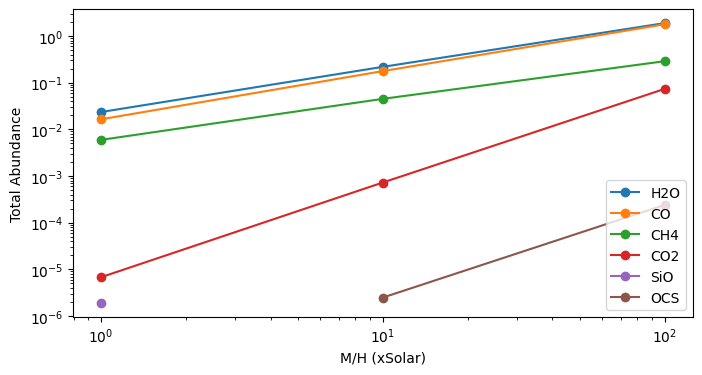

In [324]:
# Visualize how the abundance of each molecule changes as M/H increases

# Initialize an empty dictionary to store abundances
abundances = {}

# Loop through the M/H grid values
for i, mh in enumerate(mh_grid_vals):
    # Calculate total abundance of top 4 molecules for a given M/H value
    top_dict = find_top(chemistry_grid, mh=mh, co=1, n=5, method='sum')
    print(f'M/H={mh}, C/O=1:', top_dict)
    
    # Add molecule abundances dynamically and insert at the correct position
    for molecule, abundance in top_dict.items():
        if molecule not in abundances:
            abundances[molecule] = [None] * len(mh_grid_vals)  # Initialize the list with None
        abundances[molecule][i] = abundance  # Insert the abundance at the correct index

# Plot abundance vs. M/H for top 4 molecules
plt.figure(figsize=(8, 4), dpi=100)
for molecule in abundances:
    plt.plot(mh_grid_vals, abundances[molecule], marker='o', label=molecule)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('M/H (xSolar)')
plt.ylabel('Total Abundance')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
We see that most species increase in abundance as metallicity increases, and they do so at different rates.
</div>

<div class="alert alert-block alert-info">
Step 3: How do abundances change when varying C/O?
</div>

M/H=1, C/O=1: {'H2O': 0.02347246489576112, 'CO': 0.01640540306628411, 'CH4': 0.005939780830824984, 'CO2': 6.753031201009433e-06}
M/H=1, C/O=2.5: {'CO': 0.03206564994124713, 'CH4': 0.019218367983375697, 'H2O': 0.01024326280392872, 'SiO': 0.000543246569583086}


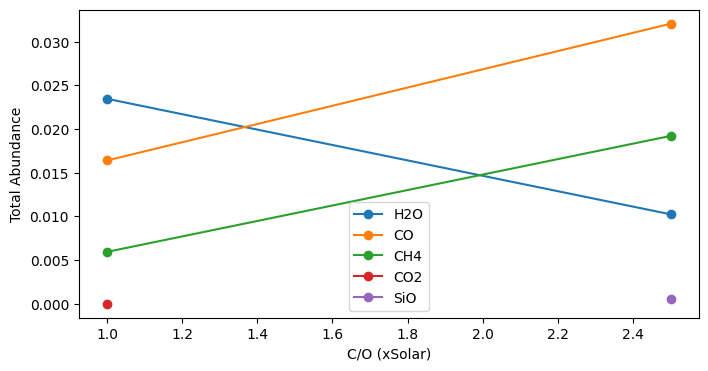

In [329]:
# Visualize how the abundance of each molecule changes as C/O increases

# Initialize an empty dictionary to store abundances
abundances = {}

# Loop through the C/O grid values
for i, co in enumerate(co_grid_vals):
    # Calculate total abundance of top 4 molecules for a given C/O value
    top_dict = find_top(chemistry_grid, mh=1, co=co, method='sum')
    print(f'M/H=1, C/O={co}:', top_dict)
    
    # Add molecule abundances dynamically and insert at the correct position
    for molecule, abundance in top_dict.items():
        if molecule not in abundances:
            abundances[molecule] = [None] * len(co_grid_vals)  # Initialize the list with None
        abundances[molecule][i] = abundance  # Insert the abundance at the correct index

# Plot abundance vs. C/O for top 4 molecules
plt.figure(figsize=(8, 4), dpi=100)
for molecule in abundances:
    plt.plot(co_grid_vals, abundances[molecule], marker='o', label=molecule)
plt.xlabel("C/O (xSolar)")
plt.ylabel("Total Abundance")
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
We see that as the ratio of carbon to oxygen increases, the abundance of carbon-bearing species (CH$_4$ and CO) grows while the abundance of H$_2$O declines.
</div>

<div class="alert alert-block alert-info">
Step 4: How does mean molecular weight vary with M/H?
</div>

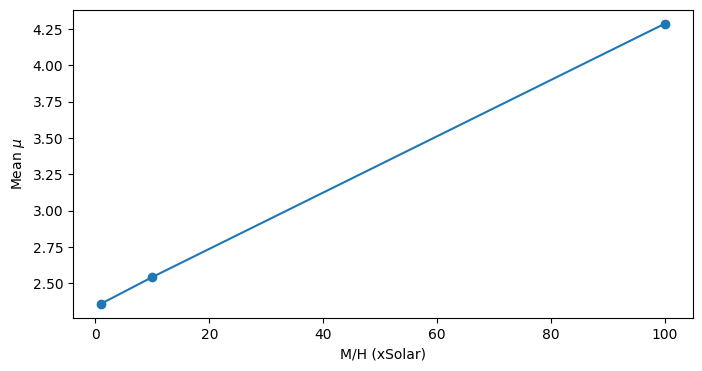

In [338]:
# Visualize how mean molecular weight changes with M/H

# Get the average mean molecular weight of the atmosphere at each M/H value
mmws = []
for mh in mh_grid_vals:
    mmws.append(np.mean(chemistry_grid[f'M/H={mh},C/O=1']['full_output']['layer']['mmw']))

# Plot how the mean molecular weight of each molecules changes with M/H
plt.figure(figsize=(8, 4), dpi=100)
plt.plot(mh_grid_vals, mmws, marker='o')
#plt.xscale('log')
plt.xlabel('M/H (xSolar)')
plt.ylabel('Mean $\\mu$')
plt.show()

<div class="alert alert-block alert-info">
We see that mean molecular weight increases linearly as M/H increases.
</div>

<div class="alert alert-block alert-info">
Step 5: Can you see this reflected in the spectrum?
<br>
<br>
What impact does the change in M/H ratio have on the spectrum? 
    
<details>
  <summary><b>Click to expand</b></summary>
<i>Why a feature might grow:</i> The strength of a spectral feature is impacted by a molecule's abundance. When we increase atmospheric metallicity, we are increasing the raw abundance of all elements heavier than hydrogen. Complicated chemical processes ensue, resulting in a new distribution of molecules constructed from those raw elements. Some molecules (e.g., CO$_2$) are more sensitive to changes in metallicity than others (e.g., H$_2$O), so although the abundance of all molecules will increase as metallicity increases, they will do so at different rates.
<br><br>
<i>Why a feature might shrink:</i> The strength of all spectral features is tied to the scale height of the atmosphere. Scale height is proportional to temperature and inversely proportional to mean molecular weight ($\mu$). If the atmosphere is heavier (i.e., bigger M/H, bigger $\mu$), its scale height will decrease (i.e. it will cling closer to the planet), and consequently all absorption features will decrease in amplitude.
<br><br>
The overall strength of any feature is related both to the molecule's abundance (which is increasing as M/H increases) and the atmosphere's scale height (which is decreasing as M/H increases).
<br><br>
<i>What's going on with CO$_2$ while M/H changes (at low C/O):</i> When C/O was held constant at a low value of 1, and M/H was varied from 1 to 10 to 100, we saw the CO$_2$ feature at 4.4 $\mu$m increased then decreased. We might infer that it crossed a certain critical M/H threshold, at which point the damping impact of the decreasing scale height overpowered the amplifying impact of the rising abundance.
<br><br>
<i>What's going on with CH$_4$ while M/H changes (at high C/O):</i> When C/O was held constant at a high value of 2.5, and M/H was varied from 1 to 10 to 100, we saw the CH$_4$ feature (embedded within H$_2$O continuum) near 3.35 $\mu$m shrink smaller and smaller. Our explorations showed that H$_2$O and CH$_4$ both increase in abundance at the same rate when M/H is increased, thus their features <i>relative to one another</i> should not change as M/H changes. However, as M/H increases, so does the mean molecular weight, and thus the scale height shrinks, causing all features to be damped. This damping explains why the CH$_4$ feature and the surrounding H$_2$O background both diminish in tandem as M/H grows.
</details>
    
<br>
What impact does the change in C/O ratio have on the spectrum?
<details>
  <summary><b>Click to expand</b></summary>
As noted above, we saw different spectral features at low vs. high C/O. We noticed when C/O is low that there is a prominent CO$_2$ feature, whereas when C/O is high we see a prominent CH$_4$ feature. As the C/O ratio increases, there is proportionally more carbon in the atmosphere, facilitating reactions that alter the relative abundance of various carbon-bearing species. One of the most important reactions that takes place is CO$_2$ + H$_2$ $\rightarrow$ CH$_4$ + H$_2$O. Generally, when C/O increases from $<$ to $>$ 2 x Solar, you go from a carbon dioxide dominated system to one dominated by methane.

</details>
</div>

## Revisiting Climate Assumption

1D Radiative-Convective Equilibrium Models solve for atmospheric structures of brown dwarfs and exoplanets, which includes:

1\. The Temperature Structure (T(P) profile)

2\. The Chemical Structure


But these physical components are not independent of each other. For example, the chemistry is dependent on the T(P) profile.

`PICASO` tries to find the atmospheric state of your object by taking care of all of these processes and their interconnections self-consistently and iteratively. Therefore, you will find that the climate portion of `PICASO` is slower than running a single forward model evaluation.

### Starting a climate run

#### Correlated-K Tables where to download them?

Earlier when we created a model atmosphere run we needed to edit our call to `opannection`. For climate calculations we need to make sure that we are covering the full range of the planetary energy distribution, which usually amounts to ~0.3-300 $\mu$m. This would be prohibitively slow if we used our same monochromatic opacities. Therefore, we instead use correlated-k tables which are on a very low resolution grid with only 196 wavelength points spanning 0.3-300 $\mu$m. We compute these correlated-K tables **as a function of M/H and C/O**. Therefore, unlike before, we are setting the chemistry of our calculation up front by specifying the correlated-K table.


<div class="alert alert-block alert-info">
^Mmm, a little fuzzy on what this means.
</div>

In [ ]:
# mh = '+100'#'+1.0' #log metallicity
# CtoO = '100'#'1.0' # CtoO ratio
# #ck_dir = 'your-path-to-correlated-tables'
# ck_db = os.path.join(ck_dir,
#                      f'sonora_2020_feh{mh}_co_{CtoO}.data.196')

# opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities



In [ ]:
##### REWA #####

# I already defined my path to the sonora correlated k files at the top of the notebook thus:
#ck_dir = os.path.join(picaso_data_dir, 'correlated_k_tables')

mh = '+100'#'+1.0' # log metallicity
CtoO = '100'#'1.0' # CtoO ratio
ck_db = os.path.join(ck_dir,
                     f'sonora_2020_feh{mh}_co_{CtoO}_noTiOVO.data.196') # I had to change this line to match my data files

opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities


<div class="alert alert-block alert-info">
^I know this isn't one of the file options, but shouldn't we used mh = 100 and CtoO = 1, since we found those created the best reduced-chi-squared fit?
</div>

#### Effective and Intrinsic Temperatures

You will notice that starting a run is nearly identical as running a spectrum. However, how we will add `climate=True` to our inputs flag, telling PICASO to create a climate. Let's create a new object or "case" where we are running the exact same parameters of the star, planet but now we are going to end with the goal of having a climate model.

New Parameter: **Effective Temperature**. This excerpt from [Modeling Exoplanetary Atmospheres (Fortney et al)](https://arxiv.org/pdf/1804.08149.pdf) provides a thorough description and more reading, if you are interested.

>If the effective temperature, $T_{eff}$, is defined as the temperature of a blackbody of
the same radius that would emit the equivalent flux as the real planet, $T_{eff}$ and $T_{eq}$
can be simply related. This relation requires the inclusion of a third temperature,
$T_{int}$, the intrinsic effective temperature, that describes the flux from the planet’s
interior. These temperatures are related by:

>$T_{eff} =  T_{int} + T_{eq}$

>We then recover our limiting cases: if a planet is self-luminous (like a young giant
planet) and far from its parent star, $T_{eff} \approx  T_{int}$; for most rocky planets, or any
planets under extreme stellar irradiation, $T_{eff} \approx T_{eq}$.


<div class="alert alert-block alert-info">
^What does "starting a run" refer to here?

What does "create a climate" really mean? I thought we already "created a climate" earlier when we defined Temperature as a function of Pressure layers (and by setting T(P)=const we made it an isothermal climate).

Is it useful to define equilibrium temperature somewhere?

Why are we making a new object, rather than adding a more complex climate to our last model? Is that so we can compare the new complex climate version with the isothermal climate version?
</div>

In [ ]:
cl_run = jdi.inputs(calculation="planet", climate = True) # start a calculation

semi_major = 0.0486 # star planet distance, AU
cl_run.star(opacity_ck, temp=5400 , database='phoenix',
         metal=0.01, logg=4.45, radius=0.9, radius_unit=jdi.u.R_sun,
            #note, now we need to know the planet-star separation!
         semi_major= semi_major, semi_major_unit = jdi.u.AU)


cl_run.gravity(mass=0.28, mass_unit=jdi.u.M_jup,
             radius=1.27, radius_unit=jdi.u.R_jup)

# Intrinsic temperature of your planet in K
# Let's keep this fixed for now
tint= 200
cl_run.effective_temp(tint) # input intrinsic temperature


### Initial T(P)  Guess

Every calculation requires an initial guess of the pressure temperature profile. The code will iterate from there to find the correct solution. A few tips:

1. We recommend **using typically 51-91 atmospheric pressure levels**. Too many pressure layers increases the computational time required for convergence. Too few layers makes the atmospheric grid too coarse for an accurate calculation.

2. Start with **a guess that is close to your expected solution**. One easy way to get fairly close is by using the Guillot et al 2010 temperature-pressure profile approximation.


In [ ]:
nlevel = 91 # number of plane-parallel levels in your code

# Let's set the max and min at 1e-4 bars and 500 bars
pt = cl_run.guillot_pt(equilibrium_temperature, nlevel=nlevel, T_int = tint, p_bottom=2, p_top=-6)
temp_guess = pt['temperature'].values
pressure = pt['pressure'].values

<div class="alert alert-block alert-info">
^The comment in the above block of code says it's setting the pressure from 10^-4 to 500 bars. But the next line actually sets it from from 10^-6 to 10^2, which is 1 microbar to 100 bars of pressure. Which is it?
</div>

### Initial Convective Zone Guess

You also need to have a crude guess of the convective zone of your atmosphere. Generally the deeper atmosphere is always convective. Again a good guess is always the published SONORA grid of models for this. But lets assume that the bottom 7 levels of the atmosphere is convective.

<div class="alert alert-block alert-info">
^When it says "Again a good guess is always the published SONORA grid of models for this," it makes it sound like this was discussed before, but this is the first mention of convection or the purpose of SONORA.
</div>

**New Parameters:**

1. `nofczns` : Number of convective zones. Though the code has functionality to solve for more than one. In this basic tutorial, let's stick to 1 for now.
2. `rfacv`: (See Mukherjee et al Eqn. 20 `r_st`) https://arxiv.org/pdf/2208.07836.pdf

Non-zero values of rst (aka "rfacv" legacy terminology) is only relevant when the external irradiation on the atmosphere is non-zero. In the scenario when a user is computing a planet-wide average T(P) profile, the stellar irradiation is contributing to 50% (one hemisphere) of the planet and as a result rfacv = 0.5. If instead the goal is to compute a night-side average atmospheric state, rfacv is set to be 0. On the other extreme, to compute the day-side atmospheric state of a tidally locked planet rfacv should be set at 1.

In [ ]:
nofczns = 1 # Number of convective zones initially. Let's not play with this for now.

nstr_upper = 85 # Top most level of guessed convective zone.
nstr_deep = nlevel -2 # This is always the case. Dont change this.
nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # Initial guess of convective zones.

# Here are some other parameters needed for the code.
rfacv = 0.5 # Let's assume perfect heat redistribution.

<div class="alert alert-block alert-info">
OK so I'm understanding that pressure layers are counted from the top down, where the top of the atmosphere is the first layer (1) and has the lowest pressure, and the bottom (ground-hugging) 7 layers of the atmosphere are the most dense and convective (layers 85-91)?
</div>

Now we would use the inputs_climate function to input everything together to our cl_run we started.

In [ ]:
cl_run.inputs_climate(temp_guess = temp_guess, pressure = pressure,
                      nstr = nstr, nofczns = nofczns, rfacv = rfacv)

### Run the Climate Code

 The actual climate code can be run with the cl_run.run command. The save_all_profiles is set to True to save the T(P) profile at all steps. The code will now iterate from your guess to reach the correct atmospheric solution for your exoplanet.

This will take a few minutes (~3 to 10 min)

In [ ]:
clima_out = cl_run.climate(opacity_ck, save_all_profiles=True, with_spec=True)

Let's visually confirm the convergence through a plot animation

In [ ]:
ani = jpi.animate_convergence(clima_out, cl_run, opacity_ck,
                              calculation='transmission',
    molecules=['H2O','CH4','CO','CO2'])

In [ ]:
ani

<div class="alert alert-block alert-info">
How are the animations showing a convergence? What is converging? I'm not sure what I'm supposed to get out of these plots. 
</div>

Nice! Our initial parameterized guess wasn't too far from the final converged solution. Let's add this climate pressure-temperature chemical information we just made back to our original WASP-39b object or "case", and see how it affects our spectrum.

In [ ]:
# Let's go back to our initial object or "case" that we were using for our transit spectra.
w39.atmosphere(df=clima_out['ptchem_df'])
df_spec = w39.spectrum(opa, calculation='transmission', full_output=True)
show_spectra({'clima':df_spec})

print(f'Converged Climate Model Chi sq=', chisqr(df_spec ))

### Add manual chemistry to model

Let's create an object or "case" where SO$_2$ is present and see if that will create a model with a better fit to the data.

In [ ]:
so2_case = jdi.copy.deepcopy(w39)
# Let's consider again our simple cloud case
so2_case.clouds(p=[1], dp=[4.5], opd=[1], g0=[0], w0=[0])

# Let's explore
so2_abundance = [1e-7,1e-6,1e-5]
so2_models = {}
for iso2 in so2_abundance:
    so2_case.inputs['atmosphere']['profile']['SO2']=iso2
    df_spec_so2 = so2_case.spectrum(opa, calculation='transmission',full_output=True)
    so2_models[f'{iso2}']=df_spec
    print(f'Chi-Sq of SO2={iso2}:' ,chisqr(df_spec))
show_spectra(so2_models)

<div class="alert alert-block alert-info">
^All three so2 models are identical, so you only see the final (yellow) line that is plotted. Also it looks the same as the plot in the previous section (7.3.4). There was a typo in the code (it used df_spec instead of df_spec_so2), fixed below.

This is the first time we've considered clouds, so I'm not sure why the comment says "Let's consider again..." Why does adding sulfur dioxide introduce clouds?
</div>

In [ ]:
##### REWA #####

so2_case = jdi.copy.deepcopy(w39)
# Let's consider again our simple cloud case
so2_case.clouds(p=[1], dp=[4.5], opd=[1], g0=[0], w0=[0])

# Let's explore
so2_abundance = [1e-7,1e-6,1e-5]
so2_models = {}
for iso2 in so2_abundance:
    so2_case.inputs['atmosphere']['profile']['SO2']=iso2
    df_spec_so2 = so2_case.spectrum(opa, calculation='transmission',full_output=True)
    so2_models[f'{iso2}']=df_spec_so2 # This line had the typo
    print(f'Chi-Sq of SO2={iso2}:' ,chisqr(df_spec_so2)) # This line had the typo
show_spectra(so2_models)

<div class="alert alert-block alert-info">
Looks like adding sulfur dioxide with an abundance of 1e-05 improved the fit!
</div>

# Xarray output (.nc) the model

Now that we have our models created and all done, let's save our climate model as an [Xarray](https://docs.xarray.dev/en/stable/). This is a great tool to neatly wrap all of your models. This is very useful because we can continue our analysis from low-fidelty PICASO to the high fidelty bayesian fitting (which is the next tutorial)! It also allows anyone else to take a look and analyze the models you have created very easily.

## Save W39 case w/o SO2

In [ ]:
# savefile="W39b_climate.nc"
# xarr_no_so2=jdi.output_xarray(df_spec, w39, savefile=os.path.join(picaso_tutorial_dir, savefile))

In [ ]:
##### REWA #####

savefile="W39b_climate.nc"
xarr_no_so2=jdi.output_xarray(df_spec, w39, savefile=os.path.join(w39_data_dir, savefile))

In [ ]:
xarr_no_so2

### Access Xarray values similarly to a regular array

In [ ]:
xarr_no_so2.keys()

In [ ]:
xarr_no_so2['temperature']

## Save SO2 case

In [ ]:
# savefile="W39b_climate_so2.nc"
# xarr_so2=jdi.output_xarray(df_spec_so2, so2_case, savefile=os.path.join(picaso_tutorial_dir, savefile))

In [ ]:
##### REWA #####

savefile="W39b_climate_so2.nc"
xarr_so2=jdi.output_xarray(df_spec_so2, so2_case, savefile=os.path.join(w39_data_dir, savefile))

In [ ]:
xarr_so2

### Access Xarray values similarly to a regular array

In [ ]:
xarr_so2.keys()

In [ ]:
xarr_so2['pressure']

Note that this has been a simplfied analysis of WASP-39b. A further analysis would include thick/thin clouds and photochemistry, which is below!

## Further Complex Modeling with Virga

Unfortunately, not every analysis will be this simple! In the case of WASP-39b, there may be some extra chemicals in the atmosphere (like SO2 we just added!) or even clouds we will have to "inject" into the model after the core parameters. In this section, we will be focusing on the basics of `virga` and how clouds are introduced and affect the complexity of your model.

You should already have [virga](https://natashabatalha.github.io/virga/installation.html) installed from the notebook `AnalyzeExoplanet_1_picaso_setup`. Let's first begin by seeing what gas condensates we can work with.

Let's import virga and re-open that PICASO analysis we just did above.

### Importing Virga and Xarray

In [ ]:
# Here is virga
import virga.justdoit as vjdi
import virga.justplotit as vjpi
from bokeh.io import output_notebook
from bokeh.plotting import show, figure
from bokeh.palettes import Colorblind


In [ ]:
# # Open xarray
# import xarray as xr
# xarr_no_so2 = xr.open_dataset(os.path.join(picaso_tutorial_dir,"W39b_climate.nc"))
# xarr_no_so2

In [ ]:
##### REWA #####

# Open xarray
import xarray as xr
xarr_no_so2 = xr.open_dataset(os.path.join(w39_data_dir,"W39b_climate.nc"))
xarr_no_so2

### Choosing a Gas Condensate

In [ ]:
# Check gas species to choose from
vjdi.available()

We have a lot to choose from! If you already know which you want present, then you can skip past to the next section. Otherwise, let's see what recommended gas condensates virga believes we should look into more.

In [ ]:
pressure = xarr_no_so2['pressure']
temperature = xarr_no_so2['temperature']
metallicity = 1 # Atmospheric metallicity relative to Solar (for anything above 1, you will need to do your own chemical equilbrium)
mean_molecular_weight = 2.2 # Atmospheric mean molecular weight

# Get virga recommendation for which gases to run
recommended = vjdi.recommend_gas(pressure, temperature, metallicity, mean_molecular_weight)
# Print the results
print(recommended)

Virga recommends that we use the following gases above. Although Virga recommends it, it doesn't mean you need to have it or it is even there physically. It is simply stating that these gases can physically exist, although they may not be present. For the sakes of this tutorial, we will be choosing *MnS, Na2S, MgSi03*. 

**NATASHA: can you put some more science on why we chose those and the importance.**

### Creating a Case and Running the Code

Our next step is to define our Mie scattering directory and begin to build our object with the appropriate atmosphere, gravity, etc just as we did in PICASO. Mie scattering is based off the Mie theory, which describes the behavior of electromagnetic waves (light) scattering when encounteirng a homogeneous sphere (a planet in our case) based upon angle, wavelength, and polarization **NATASHA CHECK IM RIGHT**. The code uses [PyMieScatt](https://pymiescatt.readthedocs.io/en/latest/), which has extensive [documentation](https://pymiescatt.readthedocs.io/en/latest/forward.html) on how everything is calculated. Feel free to follow the documentation for more mathematical explanations of how this theory works, which is outside the scope of this tutorial.

In [ ]:
# mieff_dir = ''

In [ ]:
###### REWA #####

# I already made this directory at the top, thus:
#mieff_dir = os.path.join(picaso_data_dir, 'virga')

In [ ]:
# Let's build our "case" for WASP-39 with clouds!

w39_clouds = vjdi.Atmosphere(['MnS', 'Na2S', 'MgSiO3'],
                  fsed=1, mh=metallicity,
                  mmw = mean_molecular_weight)

kz = np.zeros(91)+1e10 # Should be equal to pressure length

# Set the planet gravity
w39_clouds.gravity(gravity=w39.inputs['planet']['gravity'], gravity_unit=jdi.u.Unit(w39.inputs['planet']['gravity_unit']))

# Get pressure temperature profile
w39_clouds.ptk(df = jdi.pd.DataFrame({
                'pressure':pressure,
                'temperature':temperature, 'kz':kz}))

# Get full dictionary output
all_out = vjdi.compute(w39_clouds, as_dict=True,
                      directory=mieff_dir)

<div class="alert alert-block alert-info">
What's kz?
</div>

Now that we have run the code and computed the cloud modeling, there is many different plots we can call from the `virga.justplotit` class to see what we are looking at exactly! But first, let's get a read of what variables and information we have access to.

In [ ]:
all_out.keys()

Lot's of choices to index to and see, but let's visually plot and gain more information of what the clouds will look like.

### Checking and Proving Gas Condensate

The first plot we can create is our P-T profile with all of the chemicals respective P-T profiles. The thick lines are the gasses that we defined two cells above to be present in our cloud modeling. Anything to the right of the black dotted line, the user input, is a gas that more than likely can condensate in the atmosphere. 

As we can see, *MgSi02* and *MnS* condensates, as their P-T profiles are to the right of ours. But, we can see that *Na2s* is to the **left** of ours, which means that it is **not** condensating in the cloud mixture.

In [ ]:
show(vjpi.pt(all_out))

<div class="alert alert-block alert-info">
^Legend is cut off, making the plot difficult to interpret. What does a line represent? Why does an line being to the right of the black dotted line mean it will condense out?

Here's my rough interpretation of what this plot is showing: Each solid line represents the condensation temperature profile for a given molecule or element. Take the thick red MgSiO3 line as an example. If an atmosphere's temperature pressure conditions fall to the right of the red line (higher temp or lower pressure), any MgSiO3 present in the atmosphere will be in its gaseous state. If atmospheric temperature pressure conditions fall to the left of the red line (lower temp or higher pressure), MgSiO3 will be in its liquid state (condensate). The dotted black line represents the conditions of WASP-39 b's atmosphere. We can infer that at high alitudes (lower pressure), WASP-39 b's atmospheric conditions are left (colder) than the red line, thus MgSiO3 may condensate. At lower altitudes (higher pressure), WASP-39 b's atmospheric conditions are right (warmer) than the red line, thus MgSiO3 will remain gaseous.
</div>

We can confirm that Na2S is not condensating by plotting the optical depth by pressure, and seeing that both *MnS* and *MgSi03* condensate as they are visible on the graph, but *Na2S* is not visible, which means it is not condensating and it's too hot with too much pressure!

<div class="alert alert-block alert-info">
^I'm not clear what this plot shows or how condensation relates to optical depth, besides the fact that when elements condense they increase the optical depth of the atmosphere because cloud are good at blocking light.
</div>

In [ ]:
show(vjpi.opd_by_gas(all_out))

Let's triple confirm by checking the Condensate MMR plot, or the mean molecule ratio condensation plot, or at what pressure does how much gas condensate for each gas. We can clearly see that MnS and MgSiO3 are present and condensing, but Na2S doesn't for reasons we have already described.

In [ ]:
show(vjpi.condensate_mmr(all_out))

### Analyzing Cloud Interactions

Next, we can take visualizing the single scattering albedo, optical depth, and the asymmetry. Let's dissect each of these and see what they mean exactly.

- Single Scattering Albedo

This plots the pressure against the wavelength to find where the albedo is strongest (i.e. where in the atmosphere higher or lower fractions of light are being reflected). We see that near the top, the albedo is close to or is 1. This means that most of the light absorbed at this layer is reflected, which makes sense! Planets, specifically puffy planets like WASP-39 b, will reflect a lot of light near the top. As we go deeper, we can see that below 1.4E-3 bars the albedo begins to drop a bit. As the light drops deeper into the atmosphere, it is a lower fractional reflection. Moving from left to right can also tell us how much light is being reflected in the infrared, visual and ultraviolet!


- Cloud Optical Depth

Optical depth refers to how well the clouds block the light and how deep. For instance, on this middle plot it can be seen at the lower pressures near the top there is a lot of light being let in (typically clouds do not form at super low pressure). As we go deeper in the atmosphere, the clouds begin to block more and more light.

- Asymmetry Parameter

**NATASHA: I KNOW YOU TOLD ME BUT I FORGOT TO WRITE IT DOWN IM SORRY :(**

In [ ]:
show(vjpi.all_optics(all_out))

<div class="alert alert-block alert-info">
Looks like this section is still in progress.

Can we change the format of the plots so the x-axis units are readable?
</div>

Awesome! This tells us so much about the interaction of clouds between the atmosphere, and is a much different analysis than a cloud free model. This is just a brief overview of what virga can do and the amount of science that can be retrieved from just one set of JWST data. For more information, please feel free to visit the [virga](https://natashabatalha.github.io/virga/index.html) documentation!